In [1]:
import pandas as pd
import numpy as np
from myst_nb import glue
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.lines import Line2D
from scipy.stats import multinomial

# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF; text-align:right'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 14px;'}
table_data = {'selector': 'td', 'props': 'padding: 14px;'}
table_caption = {'selector': 'caption', 'props': 'font-size: 14px; font-style: italic; caption-side: bottom; text-align: left; margin-top: 10px'}
table_css_styles = [even_rows, odd_rows, table_font, header_row, table_caption]


table_large_data = {'selector': 'tr', 'props': 'font-size: 14px; padding: 12px;'}
table_large_font = [even_rows, odd_rows, table_large_data, header_row, table_caption]

work_data = pd.read_csv('resources/data/checks/hist_leman.csv')
ps = pd.read_csv('resources/data/macro_data_linearm.csv')
ps = ps[ps.code == 'G70'].copy()
ps.rename(columns={'échantillon':'sample_id', 'Plage':'location', 'quantité':'quantity'}, inplace=True)

pbeaches = pd.read_csv('resources/data/u_asl_beaches.csv')
pbeaches.drop_duplicates(['location', 'city'], inplace=True)
ps_cities = pbeaches[['location', 'city']].set_index('location')

ps['city'] = ps.location.apply(lambda x: ps_cities.loc[x, 'city'])

locs_2022 = pd.read_csv('resources/data/asl_beaches.csv')
locs_2022 = locs_2022[["Plage", "x", "y"]].copy()
locs_2022.rename(columns={"y":"longitude", "x":"latitude", "Plage":"location"}, inplace=True)
locs_2022.set_index('location', inplace=True, drop=True)

beaches = pd.read_csv('resources/data/u_beaches.csv')
beaches = beaches[['slug', 'latitude', 'longitude']].set_index('slug')

shotgun = work_data[work_data.code == 'G70'].copy()

# Plastic shotgun shell wadding

__A summary of observations on Lac Léman__

Plastic wadding is commonly used in modern shotgun shells due to its durability and consistency in performance. It helps to cushion the shot or slug as it moves down the barrel, ensuring it stays centered and providing a proper seal to maximize the energy transfer upon firing.

Plastic wadding can come in various forms, such as wads or cups, and they can have different designs depending on the specific requirements of the shotgun shell and the desired performance characteristics.

When plastic wadding is left behind after shooting activities or improperly disposed of, it can find its way into water bodies and eventually wash up on beaches. Once there, it can pose risks to wildlife through ingestion or entanglement.


## Sampling campaigns 2015 - 2022

Plastic shotgun wadding has been identified in every major sampling campaign in the Léman region since monitoring of plastics began.

1. Montreux Clean Beach Project (MCBP): November 2015 - November 2016. Sampling campaign  by local organization
2. Swiss Litter Report (SLR): April 2017 - May 2018. Sampling campaign by the WWF Switzerland.
3. Identification Qauntitification of Anthropogenc Litter Switzerlnd (IQAASL): April 2020 - May 2021. Sampling campaign mandated by the Swiss confederation. 
4. Pla'stock: January 2022 - December 2022. Sampling campaign by Association pour la Sauvegard du Léman.

### Essential statistics: 2015 - 2021

In [2]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

start_date, end_date = shotgun["date"].min(), shotgun['date'].max()
nsamples = len(shotgun)
ncities = shotgun.city.nunique()
nlocations = shotgun.location.nunique()

qty = shotgun.quantity.sum()
fail_rate = np.mean(shotgun.quantity > 0)
found_qtle = np.quantile(shotgun.quantity.values, quantiles)
density_qtle = np.quantile(shotgun['pcs/m'].values, quantiles)
dqtle = {quantiles[i]: int(x * 100) for i, x in enumerate(density_qtle)}
found_median, found_mean = shotgun.quantity.median(), shotgun.quantity.mean()

median_density, average_density = shotgun['pcs/m'].median(), shotgun['pcs/m'].mean()

summary_2015_2021 = f"""

From {start_date} to {end_date} a total of {qty} plastic waddings (PW) were found in {nsamples} separate samples. The samples were from {nlocations} different locations,
representing {ncities} different municipalities and three cantons. PW were indentified in {int(fail_rate * 100)}% of samples. The average number found per sample was {int(found_mean)}, 
the median contamination per meter of shoreline was {median_density}. Which means that we found at leat 1 PW for every two trips to the beach and it was not uncommon to find more.

On a per meter basis (pcs/m) we found on average {round(average_density, 2)} PW for every meter. Values in excess of 50 PW per 100 meters were encountered less than 5% of the time.
"""

Markdown(summary_2015_2021)



From 2015-11-23 to 2021-11-14 a total of 949 plastic waddings (PW) were found in 250 separate samples. The samples were from 38 different locations,
representing 15 different municipalities and three cantons. PW were indentified in 54% of samples. The average number found per sample was 3, 
the median contamination per meter of shoreline was 0.02. Which means that we found at leat 1 PW for every two trips to the beach and it was not uncommon to find more.

On a per meter basis (pcs/m) we found on average 0.1 PW for every meter. Values in excess of 50 PW per 100 meters were encountered less than 5% of the time.


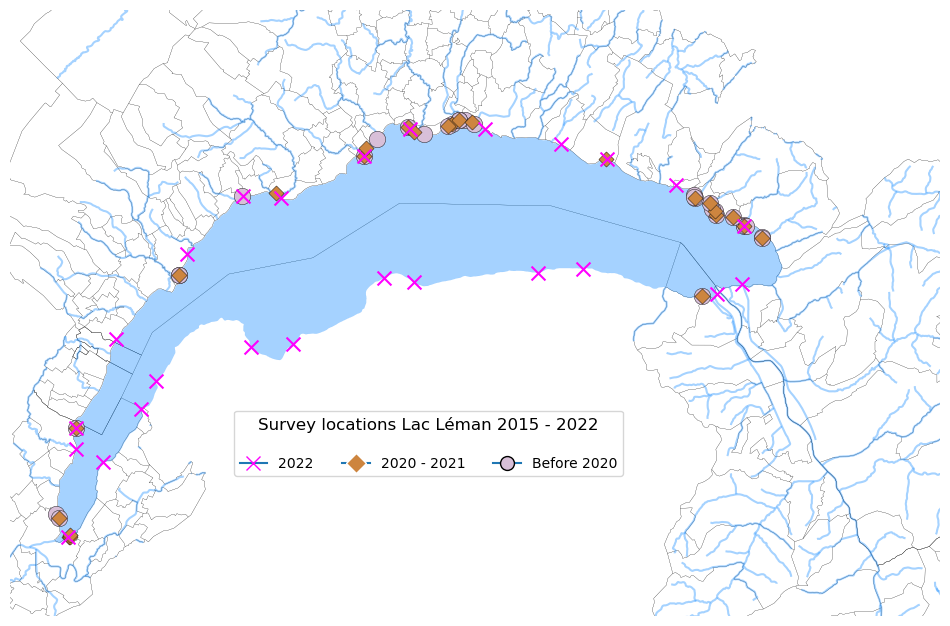

In [3]:
# Create a GeoDataFrame from the list of locations

def map_markers(df, lat_lon: pd.DataFrame = None):
    """Map the markers"""
    nsamples = df.groupby('location', observed=True)['sample_id'].nunique()
    qty_location = df.groupby('location', observed=True)['quantity'].sum()
    rate_location = df.groupby('location', observed=True)['pcs/m'].mean().round(2)
    last_sample = df.groupby('location', observed=True)['date'].max()
    dfx = pd.concat([nsamples, qty_location, rate_location, last_sample], axis=1)
    dfi = dfx.merge(lat_lon, left_index=True, right_index=True)
    dfi['location'] = dfi.index
    max_lat, min_lat = dfi['latitude'].max(), dfi['latitude'].min()
    max_lon, min_lon = dfi['longitude'].max(), dfi['longitude'].min()
    td = dfi.to_dict(orient='records')
    geometry = [Point(loc['longitude'], loc['latitude']) for loc in td]
    geo_frame = gpd.GeoDataFrame(td, geometry=geometry, crs="EPSG:4326")
    
    return geo_frame 


cantons = ['Vaud', 'Valais', 'Genève']
dbc = gpd.read_file('resources/data/ignorethis/shapes/kantons.shp')
dbc = dbc.to_crs(epsg=4326)
dbc = dbc[dbc.NAME.isin(cantons)].copy()
dbckey = dbc[['NAME', 'KANTONSNUM']].set_index('NAME')
dbckey = dbckey.drop_duplicates()
thiscanton = dbckey.loc[cantons, 'KANTONSNUM']
db = gpd.read_file('resources/data/ignorethis/shapes/municipalities.shp')
db = db.to_crs(epsg=4326)
thesecities = db[db.KANTONSNUM.isin(thiscanton.values)]
surveyedcities = work_data.city.unique()

bounds = dbc.total_bounds
minx, miny, maxx, maxy = 6.1, 46.15, 7.1, 46.6


rivers = gpd.read_file('resources/data/ignorethis/shapes/rivers.shp')
rivers = rivers.to_crs(epsg=4326)
# Filter the background layer to cover the bounding box
rivers_within_bounds = rivers.clip(dbc, keep_geom_type=True) # cx[minx:maxx, miny:maxy]


lakes = gpd.read_file('resources/data/ignorethis/laclemanfilled.shp')
lakes = lakes.to_crs(epsg=4326)
# lakes_within_bounds = lakes.clip(dbc, keep_geom_type=True) # [minx:maxx, miny:maxy]

# Define the plot
fig, ax = plt.subplots(figsize=(12,10))
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

dbc.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=.1, zorder=0)
citymap = thesecities.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=.1, zorder=0)
lakes.plot(ax=ax, edgecolor='dodgerblue', color='dodgerblue', linewidth=.1, alpha=.4, zorder=2)
#surveyed = thesecities[thesecities.NAME.isin(surveyedcities)].plot(ax=ax, color='salmon', alpha=0.6)


rivers_within_bounds.plot(ax=ax, edgecolor='dodgerblue', alpha=.4, zorder=0)


# lakes = lake_report.sample_results()
# prior_samples = lake_prior_report.sample_results()

locations_2022 = map_markers(ps, locs_2022)
locations_2022.plot(ax=ax, color='magenta', markersize=100, zorder=5, marker='x')

locs_before_2020 = shotgun[shotgun['date'] < '2020-01-01'].location.unique()
before_2020 = map_markers(shotgun[shotgun.location.isin(locs_before_2020)], beaches)
before_2020.plot(ax=ax, color='thistle', markersize=140, zorder=3, marker='o', edgecolor= 'black', linewidth=.3)

locations_2021 = shotgun[ (shotgun['date'] >= '2020-01-01') & (shotgun['date'] <= '2021-12-31')].location.unique()
locs_2020 = map_markers(shotgun[shotgun.location.isin(locations_2021)], beaches)
locs_2020.plot(ax=ax, color='peru', markersize=60, zorder=4, marker='D', edgecolor= 'black', linewidth=.3)

# ax.set_title(f'Survey locations Lac Léman 2015 - 2022')
plt.xlabel('')
plt.ylabel('')

plt.axis('off')



legend_elements = [
    Line2D([0], [0], marker='x', label='2022', markersize=10, markeredgecolor= 'magenta'),
    Line2D([0], [0], marker='D', label='2020 - 2021', markersize=10, markeredgecolor='w', markerfacecolor= 'peru'),    
    Line2D([0], [0], marker='o', label='Before 2020', markersize=10, markeredgecolor= 'black', markerfacecolor= 'thistle')
]

plt.legend(
    handles=legend_elements, 
    loc='upper center', 
    bbox_to_anchor=(0.45, 0.35), 
    title="Survey locations Lac Léman 2015 - 2022\n",
    title_fontsize='large',
    
    ncols=3)

glue('map-of-survey-locations', fig, display=True)
plt.close()

### Essential statistics: 2022

In 2022, contrary to the previous sampling campaigns, the french side of the lake was also sampled according to same protocol as the previous years.

In [4]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

start_date, end_date = ps["date"].min(), ps['date'].max()
nsamples = len(ps)
# ncities = ps.city.nunique()
nlocations = ps.slug.nunique()

qty = ps['quantity'].sum()
fail_rate = np.mean(ps['quantity'] > 0)
found_qtle = np.quantile(ps['quantity'].values, quantiles)
density_qtle = np.quantile(ps['pcs/m'].values, quantiles)
dqtle = {quantiles[i]: int(x * 100) for i, x in enumerate(density_qtle)}
found_median, found_mean = ps['quantity'].median(), ps['quantity'].mean()

median_density, average_density = ps['pcs/m'].median(), ps['pcs/m'].mean()


summary_2022 = f"""

From {start_date} to {end_date} a total of {qty} plastic waddings (PW) were found in {nsamples} separate samples. The samples were from {nlocations} different locations,
representing {ncities} different municipalities and three cantons. PW were indentified in {int(fail_rate * 100)}% of samples. The average number found per sample was {int(found_mean)}, 
the median found was {found_median}. Which means that for any given visit to the shoreline on Lake Geneva we found at leat 1 PW 50% of the time and it was not uncommon to find more.

On a per meter basis (pcs/m) we found on average {round(average_density, 2)} PW for every meter. The mediam was {int((found_median*100))} PW/meter. Values in excess of 50 PW per 100 meters were encountered less than 5% of the time.
"""

Markdown(summary_2022)



From 2022-01-10 to 2022-12-17 a total of 199 plastic waddings (PW) were found in 98 separate samples. The samples were from 25 different locations,
representing 15 different municipalities and three cantons. PW were indentified in 38% of samples. The average number found per sample was 2, 
the median found was 0.0. Which means that for any given visit to the shoreline on Lake Geneva we found at leat 1 PW 50% of the time and it was not uncommon to find more.

On a per meter basis (pcs/m) we found on average 0.02 PW for every meter. The mediam was 0 PW/meter. Values in excess of 50 PW per 100 meters were encountered less than 5% of the time.


### Cumulative results at a glance

In [5]:
vals_21 = shotgun['pcs/m'].values
vals_22 = ps['pcs/m'].values
all_vals = [*vals_21, *vals_22]
all_qtle = np.quantile(all_vals, quantiles)
aqtle = {quantiles[i]: int(x * 100) for i, x in enumerate(all_qtle)}
average = round(np.mean(all_vals),2)
astd = round(np.std(all_vals), 2)
nsamps = len(all_vals)
ncities = len(ps.city.unique()) + len(shotgun.city.unique())
all_q = shotgun.quantity.sum() + ps.quantity.sum()

cum_summary = f"""
In total (both periods combined) there were {nsamps} samples from {ncities} cities between 2015 - 2022 that yielded {all_q} PWs. 
The average PW per meter was {average} and the median was {all_qtle[2]} PW per meter with a standard deviation of {astd}
"""
glue('cum-summary', Markdown(cum_summary), display=False)

In [6]:
shotgun['date'] = pd.to_datetime(shotgun['date'], format='%Y-%m-%d')
ps['date'] = pd.to_datetime(ps['date'], format='%Y-%m-%d')
fig, ax = plt.subplots()
sns.scatterplot(data=shotgun, x='date', y='pcs/m', marker='x', color='peru', label="2015-2021")
sns.scatterplot(data=ps, x='date', y='pcs/m', marker='x', color='magenta', label="2022")
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_title("Le Léman plastic shotgun wadding: found on the beach 2015-2022")
plt.tight_layout()
glue('region_scatter', fig, display=False)
plt.close()

fig, ax = plt.subplots()
sns.ecdfplot(data=shotgun, x="pcs/m", label='2015-2021', color='peru')
sns.ecdfplot(data=ps, x="pcs/m", label='2022', color='magenta')
ax.set_xlim(-0.1, 1)
ax.set_ylabel("Probability")
ax.legend()
ax.set_title("Le Léman Empirical Cumulative distribution: 2015 - 2021 v/s 2022")
plt.tight_layout()
glue('region_ecdf', fig, display=False)
plt.close()

```{glue:md} cum-summary
:format: myst
```



::::{grid} 1 1 2 2

:::(grid-item-card}
```{glue} region_scatter
```
+++
The number of plastic shotgun wadding per meter 2015 - 2022
:::

:::(grid-item-card}
```{glue} region_ecdf
```
+++
The cumulative distribution of the number of plastic wadding per meter 2015 - 2021 v/s 2022
:::

::::

### Municipal results

In [7]:
# cities with more than two samples and none were found
two_or_more_samples = shotgun.groupby('city').filter(lambda x: len(x) >= 2)
cumulative_sum = two_or_more_samples.groupby('city')['quantity'].sum()
total = len(cumulative_sum[cumulative_sum == 0])

# locations where none were found
by_city = shotgun.groupby('city')['quantity'].sum()
cities_with_none = by_city[by_city == 0].index
c_none = ', '.join(cities_with_none)

cities_2021 = f"""
__Municipal results 2015 - 2021__

* Nummber of cities with two or more samples where none were found: {total}\n
* Cities where none were found, for all cities and number of samples: {c_none}\n\n
"""

glue('cities-2021', Markdown(cities_2021), display=False)

In [8]:
# cities with the highest density

city_pcs_m = shotgun.groupby('city', as_index=False).agg({'pcs/m':'mean', 'quantity': 'sum', 'sample_id':'nunique'})
cpm = city_pcs_m.rename(columns={'sample_id':'nsamples'}, inplace=True)
cpm = city_pcs_m.sort_values(by='pcs/m', ascending=False).set_index('city', drop=True)
cpm.index.name = None
cp = cpm.style.set_table_styles(table_css_styles).format(precision=2)
glue('city-rankings-21', cp, display=False)

In [9]:
# cities with more than two samples and none were found
two_or_more_samples = ps.groupby('city').filter(lambda x: len(x) >= 2)
cumulative_sum = two_or_more_samples.groupby('city')['quantity'].sum()
total = len(cumulative_sum[cumulative_sum == 0])

# locations where none were found
by_city = ps.groupby('city')['quantity'].sum()
cities_with_none = by_city[by_city == 0].index
c_none = ', '.join(cities_with_none)

cities_2022 = f"""
__Municipal results 2022__

* Nummber of cities with two or more samples where none were found: {total}\n
* Cities where none were found, for all cities and number of samples: {c_none}\n\n
"""

glue('cities-2022', Markdown(cities_2022), display=False)

In [10]:
# cities with the highest density

city_pcs_m = ps.groupby('city', as_index=False).agg({'pcs/m':'mean', 'quantity': 'sum','sample_id':'nunique'})
cpm = city_pcs_m.rename(columns={'sample_id':'nsamples'}, inplace=True)
cpm = city_pcs_m.sort_values(by='pcs/m', ascending=False).set_index('city', drop=True)
cpm.index.name = None
cp = cpm.style.set_table_styles(table_css_styles).format(precision=2)
glue('city-rankings-22', cp, display=False)

:::::{grid} 1 1 2 2

::::{grid-item-card}
```{glue:md} cities-2021
:format: myst
```
^^^
```{glue} city-rankings-21
```

::::

::::{grid-item-card}
```{glue:md} cities-2022
:format: myst
```
^^^
```{glue} city-rankings-22
```

::::

:::::

## Regional results

In [11]:
psregions = ps.groupby(['location', 'region'], as_index=False)['pcs/m'].mean()
psregions = ps.groupby(['region'], as_index=False)['pcs/m'].mean()
sregion = shotgun.groupby(['location','region'], as_index=False)['pcs/m'].mean()
sregion = shotgun.groupby(['region'], as_index=False)['pcs/m'].mean()

psr = psregions.style.set_table_styles(table_css_styles).format(precision=2).hide(axis='index')

glue('plastock-regions', psr, display=False)
sdr = sregion.style.set_table_styles(table_css_styles).format(precision=2).hide(axis='index')
glue('prior-regions', sdr, display=False)


:::::{grid} 1 1 1 1
:gutter: 1

::::{grid-item}
:columns: 12
Lake Geneva is divided into three parts because of its different types of formation (sedimentation, tectonic folding, glacial erosion):

* Haut Lac ('Upper Lake'), the eastern part from the Rhône estuary to the line of Meillerie–Rivaz
* Grand Lac ('Large Lake'), the largest and deepest basin with the lake's largest width
* Petit Lac ('Small Lake'), the most south-west, narrower and less deep part from Yvoire–Promenthoux next Prangins to the exit in Geneva

For a brief description of the geography of Lac Léman see: [Wikepedia Lake Geneva](https://en.wikipedia.org/wiki/Lake_Geneva)
::::

::::{grid} 3
:gutter: 1

:::{grid-item-card}
:columns: 4
Average PW per meter 2015 - 2021

^^^
```{glue} prior-regions
```
:::

:::{grid-item-card}
:columns: 4
The regional results mirror the results by time frame, that is in general we found less PW in 2022 than the previous years.
However, whether you sampled in 2022 or 2021, the average values were higher in the Grand and Haut lac as opposed to the Petit
lac.
:::

:::{grid-item-card}
:columns: 4
Average PW per meter 2022

^^^

```{glue} plastock-regions
```
:::


::::

:::::

### Where did we find the most ?

The 75th percentile of all the samples is 0.06 pcs/m or 6 PW for every 100m. The map below shows the locations where the average number per meter exceeded 0.06 pcs/m.

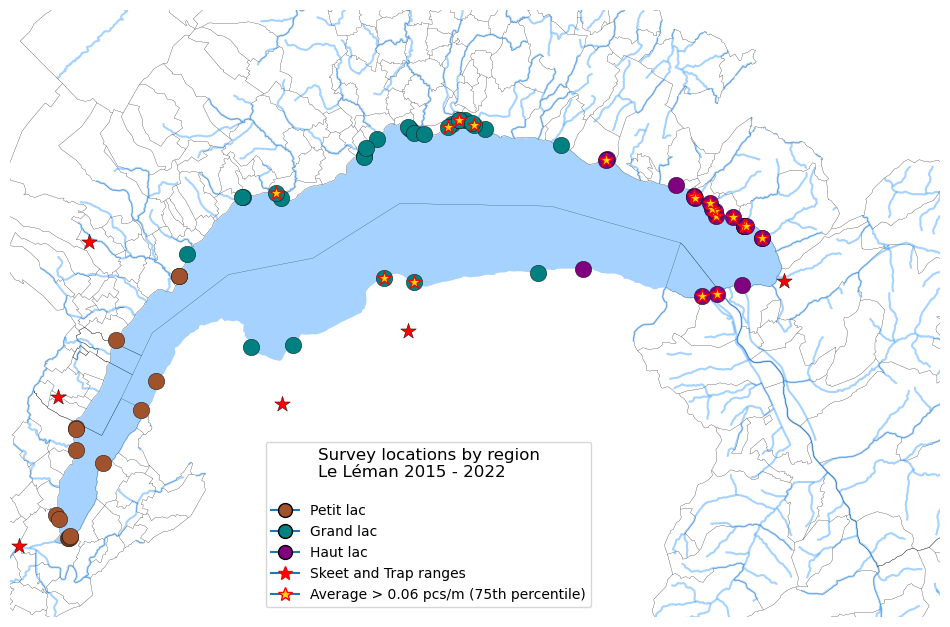

In [12]:
cantons = ['Vaud', 'Valais', 'Genève']
dbc = gpd.read_file('resources/data/ignorethis/shapes/kantons.shp')
dbc = dbc.to_crs(epsg=4326)
dbc = dbc[dbc.NAME.isin(cantons)].copy()
dbckey = dbc[['NAME', 'KANTONSNUM']].set_index('NAME')
dbckey = dbckey.drop_duplicates()
thiscanton = dbckey.loc[cantons, 'KANTONSNUM']
db = gpd.read_file('resources/data/ignorethis/shapes/municipalities.shp')
db = db.to_crs(epsg=4326)
thesecities = db[db.KANTONSNUM.isin(thiscanton.values)]
surveyedcities = work_data.city.unique()

bounds = dbc.total_bounds
minx, miny, maxx, maxy = 6.1, 46.15, 7.1, 46.6


rivers = gpd.read_file('resources/data/ignorethis/shapes/rivers.shp')
rivers = rivers.to_crs(epsg=4326)
# Filter the background layer to cover the bounding box
rivers_within_bounds = rivers.clip(dbc, keep_geom_type=True) # cx[minx:maxx, miny:maxy]


lakes = gpd.read_file('resources/data/ignorethis/laclemanfilled.shp')
lakes = lakes.to_crs(epsg=4326)
# lakes_within_bounds = lakes.clip(dbc, keep_geom_type=True) # [minx:maxx, miny:maxy]

# Define the plot
fig, ax = plt.subplots(figsize=(12,10))
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

dbc.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=.1, zorder=0)
citymap = thesecities.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=.1, zorder=0)
lakes.plot(ax=ax, edgecolor='dodgerblue', color='dodgerblue', linewidth=.1, alpha=.4, zorder=2)
#surveyed = thesecities[thesecities.NAME.isin(surveyedcities)].plot(ax=ax, color='salmon', alpha=0.6)


rivers_within_bounds.plot(ax=ax, edgecolor='dodgerblue', alpha=.4, zorder=0)

haut_lac_22 = map_markers(ps[ps.region == 'Haut lac'].copy(), locs_2022)
Grand_lac_22 = map_markers(ps[ps.region == 'Grand lac'].copy(), locs_2022)
Petit_lac_22 = map_markers(ps[ps.region == 'Petit lac'].copy(), locs_2022)


haut_lac_21 = map_markers(shotgun[shotgun.region == 'Haut lac'].copy(), beaches)
Grand_lac_21 = map_markers(shotgun[shotgun.region == 'Grand lac'].copy(), beaches)
Petit_lac_21 = map_markers(shotgun[shotgun.region == 'Petit lac'].copy(), beaches)

for place in [Petit_lac_22, Petit_lac_21]:
    place.plot(ax=ax, color='sienna', markersize=140, zorder=3, marker='o', edgecolor= 'black', linewidth=.3)

for place in [Grand_lac_22, Grand_lac_21]:
    place.plot(ax=ax, color='teal', markersize=140, zorder=3, marker='o', edgecolor= 'black', linewidth=.3)

for place in [haut_lac_22, haut_lac_21]:
    place.plot(ax=ax, color='purple', markersize=140, zorder=3, marker='o', edgecolor= 'black', linewidth=.3)

clubs = [
    {'name':'Ball-Trap Trelex', 'latitude': 46.42756392060147, 'longitude':6.1854744034687466},
    {'name':'Société de tir de Versoix', 'latitude': 46.312908641701405, 'longitude': 6.151142127645565}, 
    {'name': 'Ball-Trap club Thonon', 'latitude': 46.361859954734136, 'longitude': 6.527720761431275}, 
    {'name':'Ball-Trap club Lully', 'latitude': 46.307736036670846, 'longitude': 6.3929877398103745}, 
    {'name':'Ball-Trap club de Genève', 'latitude':46.20248337425505, 'longitude': 6.109507522514358}, 
    {'name':'Btc Ball-Trap Club', 'latitude':46.398566552478975, 'longitude':6.932542303507821}
]
clayranges = pd.DataFrame(clubs)
ctd = clayranges.to_dict(orient='records')
geometry = [Point(loc['longitude'], loc['latitude']) for loc in ctd]
geframe = gpd.GeoDataFrame(ctd, geometry=geometry, crs='EPSG:4326')
geframe.plot(ax=ax, markersize=140, zorder=3, marker='*', edgecolor= 'black', color='red', linewidth=.3)

greater_t_06 = shotgun.groupby('location')['pcs/m'].mean()
greater_t_06 = greater_t_06[greater_t_06 > 0.06].copy()

g_06_p = ps.groupby('location')['pcs/m'].mean()
g_06_p = g_06_p[g_06_p > 0.06].copy()

gthan_22 = map_markers(ps[ps.location.isin(g_06_p.index)], locs_2022)
gthan_22.plot(ax=ax, color='gold', edgecolor='red', markersize=100, zorder=6, marker='*')

gthan_21 = map_markers(shotgun[shotgun.location.isin(greater_t_06.index)], beaches)
gthan_21.plot(ax=ax, color='gold', edgecolor='red', markersize=100, zorder=6, marker='*') 

plt.xlabel('')
plt.ylabel('')

plt.axis('off')

legend_elements = [
    Line2D([0], [0], marker='o', label='Petit lac', markersize=10, markeredgecolor= 'black', markerfacecolor= 'sienna'),
    Line2D([0], [0], marker='o', label='Grand lac', markersize=10, markeredgecolor= 'black', markerfacecolor= 'teal'),    
    Line2D([0], [0], marker='o', label='Haut lac', markersize=10, markeredgecolor= 'black', markerfacecolor= 'purple'),
    Line2D([0], [0], marker='*', label='Skeet and Trap ranges', markersize=10, markeredgecolor= 'red', markerfacecolor= 'red'),
    Line2D([0], [0], marker='*', label='Average > 0.06 pcs/m (75th percentile)', markersize=10, markeredgecolor= 'red', markerfacecolor= 'gold')
           
]

plt.legend(
    handles=legend_elements, 
    loc='upper center', 
    bbox_to_anchor=(0.45, 0.3), 
    title="Survey locations by region\nLe Léman 2015 - 2022\n",
    title_fontsize='large',    
    ncols=1)

glue('map-of-survey-locations', fig, display=True)
plt.close()

## Predictions for 2025

According to the anlysis done by the _Association pour la Sauvegarde du Léman_ [predictions 2025](https://associationsauvegardeleman.github.io/plastock/description_donnee.html#analyse-et-inference) we expect the average to increase across all regions, however the median value is expected to be between 0.02 and 0.03 PW for every meter. That is we expect to find at least one PW for every two trips to the shoreline. The highest values are expected to be in the Haut lac.

The predicted distribution is a grid approximation for the sequence of values that covers the range 0 - 2 every 0.01 or more precisely:

$$x_i = 0 + 0.01 \cdot i \quad \text{for } i = 0, 1, 2, \dots, N$$

In the case where $N=20$ and assume we collect 100 samples in 2025 the expected median is .02 and the 75th is 0.04. The same as the ASL study. The predicted average under this model is 0.04, different than the model used in the ASL study because in this case we have limited the max grid. 

### Discussion

In general there should be fewer extreme incidents. However, the municipal results suggest that there are areas of higher concentration. Similarities may exist between these locations that help indicate the point source. In the case of Port Valais and Saint-Gongolph it is unlikely that the ball-trap range in proximity is the soul probable source. The stockalper canal runs through Port Valais, parallel to the Rhône with origins in Monthey, the stockalper canal has an important flow rate and can transport objects of all sizes.

Most important is the consensus on the frequency of occurence (the probability of finding at least one) return your attention to Saint Gingolph and Port Valais, they are co-located geographically and they were sampled in different years but the results are similar. In Préverenges and Vidy the same situation occurs.

In [13]:
scale = np.arange(0, 20, 0.01)

likelihood = np.array([(ps['pcs/m'] > x).sum() for x in scale])
likelihood = likelihood/98

prior = np.array([(shotgun['pcs/m'] > x).sum() for x in scale])
prior = prior/len(shotgun)

likelihood_times_prior = likelihood * prior
posterior = likelihood_times_prior/sum(likelihood_times_prior)
pminus = [1-x for x in posterior]


t = multinomial.rvs(100, p=posterior)
posterior_samples = np.repeat(scale, t)

expected_dist = np.quantile(posterior_samples, quantiles)
average = np.mean(posterior_samples)


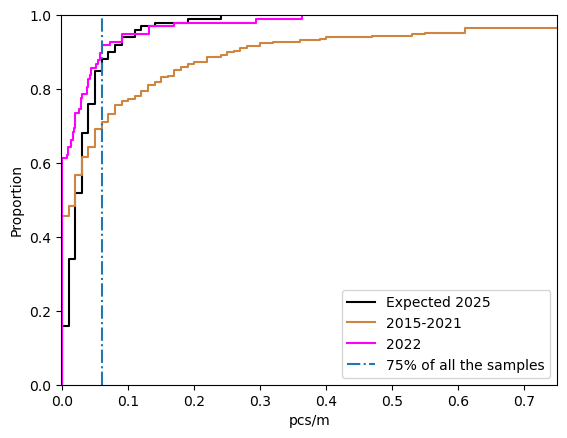

In [14]:
fig, ax =plt.subplots()

sns.ecdfplot(posterior_samples, ax=ax, color='black', label='Expected 2025')
sns.ecdfplot(data=shotgun, x="pcs/m", label='2015-2021', color='peru')
sns.ecdfplot(data=ps, x="pcs/m", label='2022', color='magenta')
plt.axvline(x=0.06, ymin=0, ymax=1, linestyle='-.', label='75% of all the samples')

ax.set_xlim(-0.001, 0.75)

ax.legend()
plt.show()

## References:

## Citizen science and data collection

(mlw_2013)=
__Guidance on Monitoring of Marine Litter in European Seas__, Galgani et all,  EUR 26113. Luxembourg (Luxembourg): 
Publications Office of the European Union; 2013. JRC83985 [https://publications.jrc.ec.europa.
eu/repository/handle/JRC83985](https://publications.jrc.ec.europa.eu/repository/handle/JRC83985)

(mlw_2023)=
__Guidance on the Monitoring of Marine Litter in European Seas An update to improve the harmonised monitoring of 
marine litter under the Marine Strategy Framework Directive__,  Galgani et all., EUR 31539 EN, Publications Office of the European Union, Luxembourg, 2023, 
ISBN 978-92- 68-04093-5, doi:10.2760/59137, JRC133594 [https://literatur.thuenen.de/digbib_extern/dn067364.pdf](https://literatur.thuenen.de/digbib_extern/dn067364.pdf)

(eu_threshold)=
__A European threshold value and assessment method for macro litter on coastlines__, Publications Office of the 
European Union, Van Loon, et all , [https://publications.jrc.ec.europa.eu/repository/handle/JRC121707](https://publications.jrc.ec.europa.eu/repository/handle/JRC121707), ISBN 978-92-76-21444-1, doi:10.2760/54369, JRC121707.

(csc_improving)=
__Improving big citizen science data: Moving beyond haphazard sampling__, _Amano, Tatsuya and Lamming, Jonathan D. L. and Sutherland, William J_, PLoS Biology, 2016, doi: 10.1371/journal.pbio.1002413, url: [https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002413](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002413).

(plastock)=
__Pla'stock : Rapport Final__, plastic stocks on Lake Geneva, Switzerland. _Association pour la Sauvegarde de Léman_, [plastock](https://associationsauvegardeleman.github.io/plastock/index.html)


(OFEV)=
__Identification, quantification and analysis of observable anthropogenic litter along Swiss lake systems__, OFEV. 2021. [IQAASL](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/)

(SLR)=
__Swiss Litter Report__, Gabrielle, Kuhl; Pascal, Blahrer; 2018; [Stopp research](http://stoppp.org/)


## Computing and mathematics

(scipy)=
__scipy: Fundamental Algorithms for Scientific Computing in Python__, _Virtanen et al_, Nature Methods, 2020, doi: 10.1038/s41592-019-0686-2.

(pandas)=
__pandas__, _The pandas development team_, Python software, 2020, doi: 10.5281/zenodo.3509134, url: [https://doi.org/10.5281/zenodo.3509134](https://doi.org/10.5281/zenodo.3509134).

(python_3)=
__Python 3 Reference Manual__, _Guido Van Rossum and Fred L. Drake_, CreateSpace, 2009, isbn: 1441412697.

(bayes_gelman)=
__Bayesian Data Analysis - Third edition__, _Andrew Gelman_, Columbia university, 2021, [http://www.stat.columbia.edu/~gelman/book/BDA3.pdf](http://www.stat.columbia.edu/~gelman/book/BDA3.pdf), doi: 10.1201/b16018.

(think_bayes)=
__Think Bayes 2ed__, _Alan Downey_, Green Tea Press, 2021, [http://allendowney.github.io/ThinkBayes2/](http://allendowney.github.io/ThinkBayes2/)

(nb_regression)=
__Regression analysis of count data. 2nd ed__, _A. Cameron and Pravin Trivedi_, Technometrics, 1999, doi: 10.1017/CBO9780511814365.

(jupyter_book)=
__Jupyter Book__, _Jupyter Book_, 2021, [https://zenodo.org/record/4539666](https://zenodo.org/record/4539666).

(bayes_hackers)=
__Bayesian Methods for Hackers__, _Cameron Davidson-Pilon_, Addison-Wesley Professional, 2021, [https://github.
com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers),
doi: 10.5555/2851115

(bayesrules)=
__Bayes Rules! An Introduction to Applied Bayesian Modeling__, _Alicia Johnson_, Chapman and Hall, 2021, 
[https://www.bayesrulesbook.com/chapter-1.html](https://www.bayesrulesbook.com/chapter-1.html), isbn: 9780367255398.

(scikit-learn)=
__scikit-learn: Machine Learning in python__, _Pedregosa et al_, Journal of Machine Learning Research, 2011, doi: 10.1109/MCSE.2007.55.

(matplotlib)=
__Matplotlib: A 2D graphics environment__, _Hunter, J. D._, Computing in Science & Engineering, 2007, doi: 10.1109/MCSE.2007.55.

(bayes_oswaldo)=
__Bayesian Analysis with Python - Second Edition__, _Martin Oswaldo_, PackT, 2020, isbn: 9781789341652.

(bayes_jaynes)=
__Probability Theory: The logic of science__, _Edwin Jaynes_, Washington University, 2003, isbn: 0521592712.

(resampling)=
__Resampling__, _Wikepedia_, 2021, [https://en.wikipedia.org/wiki/Resampling_(statistics)](https://en.wikipedia.org/wiki/Resampling_(statistics)).




## Annex

In [21]:
start_date, end_date = shotgun["date"].min(), shotgun['date'].max()
nsamples = len(shotgun)
ncities = shotgun.city.nunique()
nlocations = shotgun.location.nunique()

qty = shotgun.quantity.sum()
fail_rate = np.mean(shotgun.quantity > 0)
found_qtle = np.quantile(shotgun.quantity.values, quantiles)
density_qtle = np.quantile(shotgun['pcs/m'].values, quantiles)
dqtle = {quantiles[i]: int(x * 100) for i, x in enumerate(density_qtle)}
found_median, found_mean = shotgun.quantity.median(), shotgun.quantity.mean()

median_density, average_density = shotgun['pcs/m'].median(), shotgun['pcs/m'].mean()

summary_prior = f"""

f* number of samples : {nsamples} 
* number of cities: {ncities}
* number of locations: {nlocations}
* total objects: {qty}
* fail rate: {fail_rate}
* average: {average_density}
* median: {median_density}
"""

glue('prior-summary', Markdown(summary_prior), display=False)

In [22]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

start_date, end_date = ps["date"].min(), ps['date'].max()
nsamples = len(ps)
ncities = ps.city.nunique()
nlocations = ps.slug.nunique()

qty = ps['quantity'].sum()
fail_rate = np.mean(ps['quantity'] > 0)
found_qtle = np.quantile(ps['quantity'].values, quantiles)
density_qtle = np.quantile(ps['pcs/m'].values, quantiles)
dqtle = {quantiles[i]: int(x * 100) for i, x in enumerate(density_qtle)}
found_median, found_mean = ps['quantity'].median(), ps['quantity'].mean()

median_density, average_density = ps['pcs/m'].median(), ps['pcs/m'].mean()

summary_likelihood = f"""

* number of samples : {nsamples} 
* number of cities: {ncities}
* number of locations: {nlocations}
* total objects: {qty}
* fail rate: {round(fail_rate, 2)}
* average: {round(average_density, 2)}
* median: {median_density}
"""

glue('likelihood-summary', Markdown(summary_likelihood), display=False)

In [23]:
vals_21 = shotgun['pcs/m'].values
vals_22 = ps['pcs/m'].values
all_vals = np.array([*vals_21, *vals_22])
fail_rate = np.mean(all_vals > 0)
all_qtle = np.quantile(all_vals, quantiles)
aqtle = {quantiles[i]: int(x * 100) for i, x in enumerate(all_qtle)}
average = round(np.mean(all_vals),2)
amedian = round(np.median(all_vals), 2)
astd = round(np.std(all_vals), 2)
nsamps = len(all_vals)
ncities = len(ps.city.unique()) + len(shotgun.city.unique())
all_q = shotgun.quantity.sum() + ps.quantity.sum()


summary_all = f"""

* number of samples : {nsamps} 
* number of cities: {ncities}
* number of locations: {ps.location.nunique() + shotgun.location.nunique()}
* total objects: {ps.quantity.sum() + shotgun.quantity.sum()}
* fail rate: {fail_rate}
* average: {average}
* median: {amedian}
"""

glue('summary-all', Markdown(summary_all), display=False)

:::::{grid}

::::{grid-item-card}

All samples 2015 - 2022

^^^


```{glue:md} summary-all
:format: myst
```
::::
::::{grid-item-card}

2022

^^^

```{glue:md} likelihood-summary
:format: myst
```
::::
::::{grid-item-card}

2015 - 2021

^^^

```{glue:md} prior-summary
:format: myst
```
::::
:::::

In [18]:
import datetime as dt
from IPython.display import Markdown as md
today = dt.datetime.now().date().strftime("%d/%m/%Y")
where = "Biel, CH"

my_block = f"""

This script updated {today} in {where}

\u2764\ufe0f __what you do everyday:__ *analyst at hammerdirt*
"""

md(my_block)



This script updated 22/08/2024 in Biel, CH

❤️ __what you do everyday:__ *analyst at hammerdirt*
